In [1]:
# Config Data Structure
import IPython
import IPython.display

import pandas as pd
import numpy as np
import pprint as pp
import random as ran
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random as ran
import math

from functools import reduce
from collections import Counter
from datetime import datetime as dt
from pymongo import MongoClient as mc
from functools import reduce

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

household_col = keti_db.household_info
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

In [2]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='kw (15min)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend().remove()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [3]:
# DB Config
uid = "아파트1-103-1104"

# TimeSlot In
hh_db_datas = household_col.find_one({"uid": uid})
hh_db_datas

hh_datas = pd.DataFrame(columns=['Date Time','kw (15min)'])
timeslot = hh_db_datas['timeslot']

wt_db_datas = weather_col.find()
wt_datas = pd.DataFrame()

hh_datas['kw (15min)'] = [ts['power'] for ts in timeslot]
hh_datas['Date Time'] = [ts['time'] for ts in timeslot]

date_time = pd.to_datetime(hh_datas.pop('Date Time'), format="%Y-%m-%d T%H:%M Z")

hh_datas.index = date_time

timestamp = date_time.map(dt.timestamp)

day = 24*60*60
week = 7*day
year = (365.2425)*day

hh_datas['week sin'] = np.sin(timestamp * (2 * np.pi / week)).values
hh_datas['week cos'] = np.cos(timestamp * (2 * np.pi / week)).values
hh_datas['year sin'] = np.sin(timestamp * (2 * np.pi / year)).values
hh_datas['year cos'] = np.cos(timestamp * (2 * np.pi / year)).values

hh_datas

,kw (15min),week sin,week cos,year sin,year cos
Date Time,,,,,
2018-05-01 00:00:00,0.153,-0.846724,-0.532032,0.880785,-0.473516
2018-05-01 00:15:00,0.146,-0.851662,-0.524092,0.880700,-0.473674
2018-05-01 00:30:00,0.128,-0.856525,-0.516106,0.880615,-0.473832
2018-05-01 00:45:00,0.118,-0.861313,-0.508075,0.880530,-0.473990
2018-05-01 01:00:00,0.119,-0.866025,-0.500000,0.880445,-0.474148
...,...,...,...,...,...
2019-04-30 22:45:00,0.177,-0.958287,0.285808,0.883173,-0.469047
2019-04-30 23:00:00,0.173,-0.955573,0.294755,0.883089,-0.469205
2019-04-30 23:15:00,0.160,-0.952775,0.303677,0.883005,-0.469363


In [9]:
# Uni
uni_hh_datas = hh_datas[['kw (15min)']].copy()
# Multi
multi_hh_datas = hh_datas.copy()

In [14]:
# Split Data Code
split_datas = round(hh_datas[0::4], 3)

uni = dict()
multi = dict()
uni['split'] = round(uni_hh_datas[0::4], 3)
multi['split'] = multi_hh_datas[0::4]

In [15]:
# training datas 80%
# validation datas 10%
# validation datas 10%
val_days = []
test_days = []

val_data_percentage = 10
test_data_percentage = 10

# Mon.1 ~ Mon.12
for month in range(1,13):
    val_day_list = []
    test_day_list = []
    day_list = list(set(
        split_datas[split_datas.index.month == month].index.day
    ))
    month_datas = split_datas[split_datas.index.month == month].copy()
    start_day = day_list[0]
    end_day = day_list[len(day_list) - 1] + 1
    
    # 10 percentage split
    val_length = round(len(day_list)) / val_data_percentage
    test_length = round(len(day_list)) / test_data_percentage
    
    while True:
        if (len(val_day_list) >= val_length) and \
            (len (test_day_list) >= test_length):
            break
        while True:
            val_day = ran.randrange(start_day, end_day)
            test_day = ran.randrange(start_day, end_day)

            if (val_day != test_day) and \
                (val_day not in val_day_list + test_day_list) and \
                (test_day not in test_day_list + val_day_list):
                val_days.extend(
                    month_datas[
                        month_datas.index.day == val_day
                    ].index
                )
                test_days.extend(
                    month_datas[
                        month_datas.index.day == test_day
                    ].index
                )
                val_day_list.append(val_day)
                test_day_list.append(test_day)
                break;

train_days = split_datas.drop((val_days + test_days)).index

In [24]:
# Set Univariate Datas
uni_train_split_df = uni['split'].loc[train_days].copy()
uni_val_split_df = uni['split'].loc[val_days].copy()
uni_test_split_df = uni['split'].loc[test_days].copy()

# Set Multivariate Datas
mul_train_split_df = multi['split'].loc[train_days].copy()
mul_val_split_df = multi['split'].loc[val_days].copy()
mul_test_split_df = multi['split'].loc[test_days].copy()

In [25]:
uni_train_split_df

,kw (15min)
Date Time,
2018-05-01 00:00:00,0.153
2018-05-01 01:00:00,0.119
2018-05-01 02:00:00,0.057
2018-05-01 03:00:00,0.065
2018-05-01 04:00:00,0.067
...,...
2019-04-30 19:00:00,0.193
2019-04-30 20:00:00,0.160
2019-04-30 21:00:00,0.177


In [27]:
mul_train_split_df

,kw (15min),week sin,week cos,year sin,year cos
Date Time,,,,,
2018-05-01 00:00:00,0.153,-0.846724,-0.532032,0.880785,-0.473516
2018-05-01 01:00:00,0.119,-0.866025,-0.500000,0.880445,-0.474148
2018-05-01 02:00:00,0.057,-0.884115,-0.467269,0.880105,-0.474779
2018-05-01 03:00:00,0.065,-0.900969,-0.433884,0.879765,-0.475409
2018-05-01 04:00:00,0.067,-0.916562,-0.399892,0.879424,-0.476040
...,...,...,...,...,...
2019-04-30 19:00:00,0.193,-0.988831,0.149042,0.884431,-0.466671
2019-04-30 20:00:00,0.160,-0.982566,0.185912,0.884096,-0.467305
2019-04-30 21:00:00,0.177,-0.974928,0.222521,0.883761,-0.467939


In [28]:
uni_train_mean = uni_train_split_df.mean()
uni_train_std = uni_train_split_df.std()
print("uni split data // mean: {}, std: {}".format(uni_train_mean.values, uni_train_std.values))

uni_norm = dict({
    "all": (uni['split'] - uni_train_mean) / uni_train_std,
    "train": (uni_train_split_df - uni_train_mean) / uni_train_std,
    "val": (uni_val_split_df - uni_train_mean) / uni_train_std,
    "test": (uni_test_split_df - uni_train_mean) / uni_train_std
})

mul_train_mean = mul_train_split_df.mean()
mul_train_std = mul_train_split_df.std()
print("multi split data // mean: {}, std: {}".format(mul_train_mean.values, mul_train_std.values))

mul_norm = dict({
    "all": (multi['split'] - mul_train_mean) / mul_train_std,
    "train": (mul_train_split_df - mul_train_mean) / mul_train_std,
    "val": (mul_val_split_df - mul_train_mean) / mul_train_std,
    "test": (mul_test_split_df - mul_train_mean) / mul_train_std
})

uni split data // mean: [0.11975836], std: [0.07436508]
multi split data // mean: [ 0.11975836 -0.00726496 -0.03809834  0.00167169  0.00109157], std: [0.07436508 0.71263801 0.70056544 0.70820111 0.7061137 ]


In [29]:
uni_windows = dict()

for WINDOW_WIDTH in range(3, 21):
    uni_windows['{} hours'.format(WINDOW_WIDTH)] = WindowGenerator(
        input_width=WINDOW_WIDTH,
        label_width=1,
        shift=1,
        label_columns=['kw (15min)'],
        train_df=uni_norm['train'],
        val_df=uni_norm['val'],
        test_df=uni_norm['test']
    )
    
mul_windows = dict()
for WINDOW_WIDTH in range(3, 21):
    mul_windows['{} hours'.format(WINDOW_WIDTH)] = WindowGenerator(
        input_width=WINDOW_WIDTH,
        label_width=1,
        shift=1,
        label_columns=['kw (15min)'],
        train_df=mul_norm['train'],
        val_df=mul_norm['val'],
        test_df=mul_norm['test']
    )

In [30]:
uni_val_performance = dict()
uni_performance = dict()
uni_models = dict()

for WINDOW_WIDTH in range(3, 21):
    IPython.display.clear_output()
    key = "{} hours".format(WINDOW_WIDTH)
    print("##### UNI!! {} training start #####".format(key))
    
    cur_window = uni_windows[key]
    lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])
    
    compile_and_fit(lstm_model, cur_window)
    uni_val_performance[key] = lstm_model.evaluate(
                cur_window.val
            )
    uni_performance[key] = lstm_model.evaluate(
                cur_window.test
            )
    uni_models[key] = lstm_model

##### UNI!! 20 hours training start #####
Epoch 1/40
209/209 [==============================] - 3s 7ms/step - loss: 0.9542 - mean_absolute_error: 0.6371 - val_loss: 1.4119 - val_mean_absolute_error: 0.7293
Epoch 2/40
209/209 [==============================] - 1s 6ms/step - loss: 0.9497 - mean_absolute_error: 0.6364 - val_loss: 1.4086 - val_mean_absolute_error: 0.7324
Epoch 3/40
209/209 [==============================] - 1s 6ms/step - loss: 0.9472 - mean_absolute_error: 0.6363 - val_loss: 1.4071 - val_mean_absolute_error: 0.7333
Epoch 4/40
209/209 [==============================] - 1s 6ms/step - loss: 0.9449 - mean_absolute_error: 0.6360 - val_loss: 1.4023 - val_mean_absolute_error: 0.7409
Epoch 5/40
209/209 [==============================] - 1s 6ms/step - loss: 0.9434 - mean_absolute_error: 0.6349 - val_loss: 1.4015 - val_mean_absolute_error: 0.7412
Epoch 6/40
209/209 [==============================] - 1s 6ms/step - loss: 0.9408 - mean_absolute_error: 0.6360 - val_loss: 1.3947 - val_me

In [31]:
mul_val_performance = dict()
mul_performance = dict()
mul_models = dict()

for WINDOW_WIDTH in range(3, 21):
    IPython.display.clear_output()
    key = "{} hours".format(WINDOW_WIDTH)
    print("##### MUL!! {} training start #####".format(key))
    
    cur_window = mul_windows[key]
    lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])
    
    compile_and_fit(lstm_model, cur_window)
    mul_val_performance[key] = lstm_model.evaluate(
                cur_window.val
            )
    mul_performance[key] = lstm_model.evaluate(
                cur_window.test
            )
    mul_models[key] = lstm_model

##### MUL!! 20 hours training start #####
Epoch 1/40
209/209 [==============================] - 3s 8ms/step - loss: 0.9513 - mean_absolute_error: 0.6413 - val_loss: 1.3884 - val_mean_absolute_error: 0.7374
Epoch 2/40
209/209 [==============================] - 1s 6ms/step - loss: 0.9328 - mean_absolute_error: 0.6379 - val_loss: 1.3705 - val_mean_absolute_error: 0.7404
Epoch 3/40
209/209 [==============================] - 1s 6ms/step - loss: 0.9168 - mean_absolute_error: 0.6354 - val_loss: 1.3565 - val_mean_absolute_error: 0.7410
Epoch 4/40
209/209 [==============================] - 1s 6ms/step - loss: 0.9074 - mean_absolute_error: 0.6306 - val_loss: 1.3859 - val_mean_absolute_error: 0.7362
Epoch 5/40
32/32 [==============================] - 0s 2ms/step - loss: 0.9940 - mean_absolute_error: 0.6537


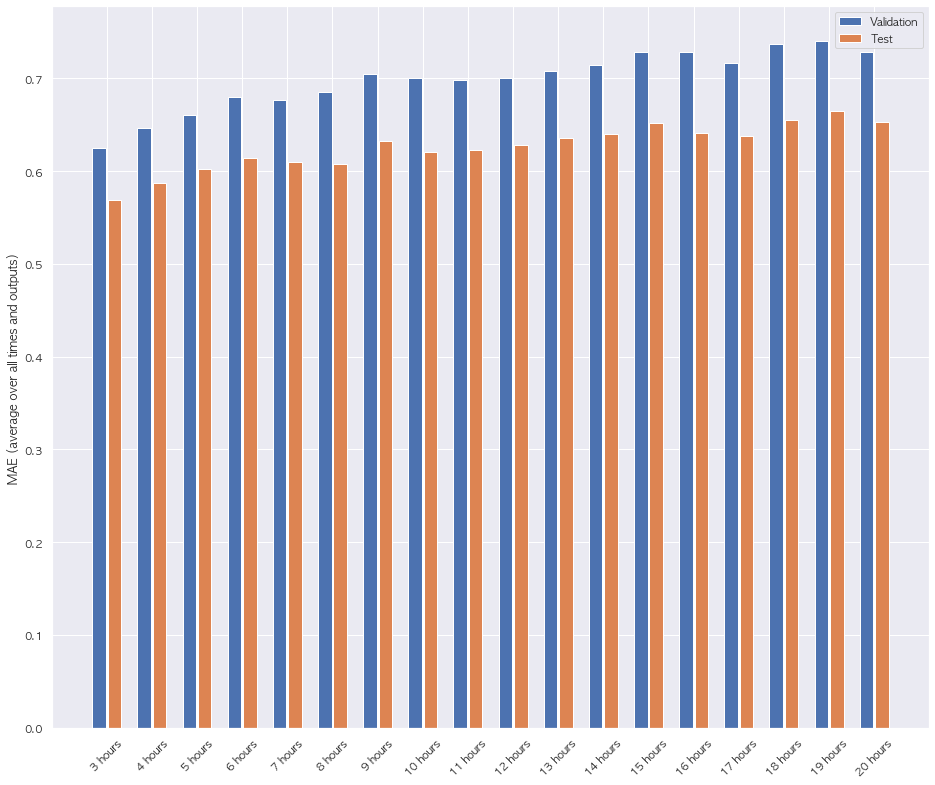

In [36]:
x = np.arange(len(uni_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in uni_val_performance.values()]
test_mae = [v[metric_index] for v in uni_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=uni_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

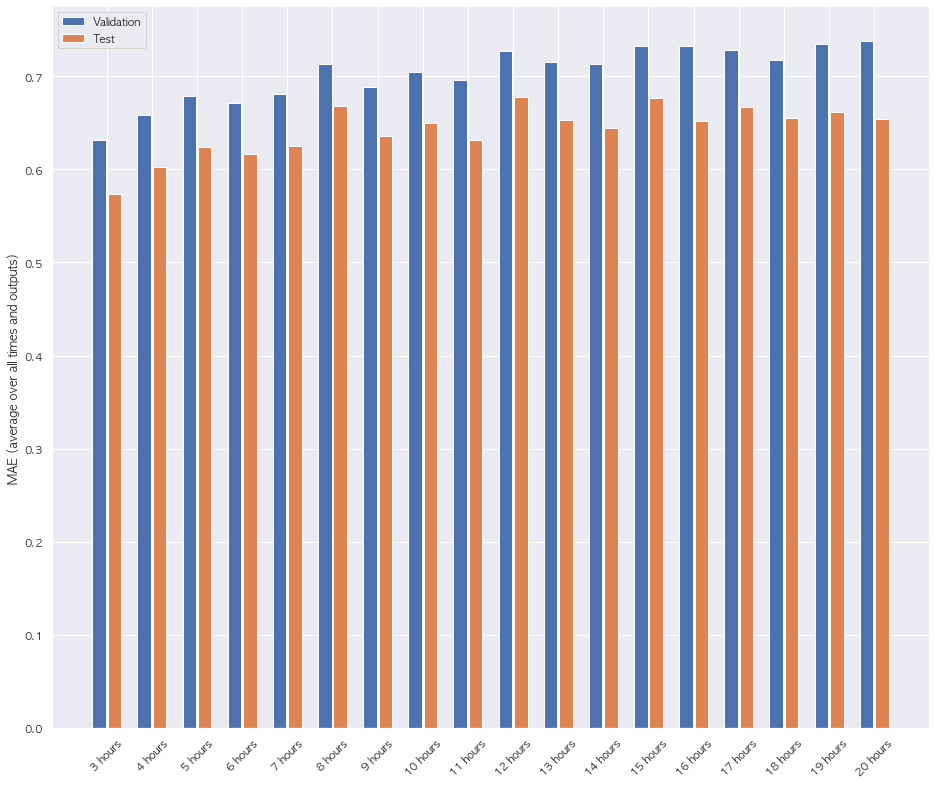

In [38]:
x = np.arange(len(mul_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in mul_val_performance.values()]
test_mae = [v[metric_index] for v in mul_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=mul_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [56]:
uni_val_pers = np.array([])
uni_pers = np.array([])

for _, key in enumerate(uni_performance):
    uni_val_pers = np.append(uni_val_pers, uni_val_performance[key])
    uni_pers = np.append(uni_pers, uni_performance[key])

print("###### Performance Check!!! ######")
print("uni val min", uni_val_pers.min())
print("uni min", uni_pers.min())
print("uni val mean", uni_val_pers.mean())
print("uni mean", uni_pers.mean())

print("")

mul_val_pers = np.array([])
mul_pers = np.array([])
for _, key in enumerate(mul_performance):
    mul_val_pers = np.append(mul_val_pers, mul_val_performance[key])
    mul_pers = np.append(mul_pers, mul_performance[key])
    
print("mul val min", mul_val_pers.min())
print("mul min", mul_pers.min())
print("mul val mean", mul_val_pers.mean())
print("mul mean", mul_pers.mean())

###### Performance Check!!! ######
uni val min 0.6253401637077332
uni min 0.5684176683425903
uni val mean 1.008358895778656
uni mean 0.8253395292494032

mul val min 0.6312990188598633
mul min 0.5733966827392578
mul val mean 0.9847629020611445
mul mean 0.8162995328505834


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

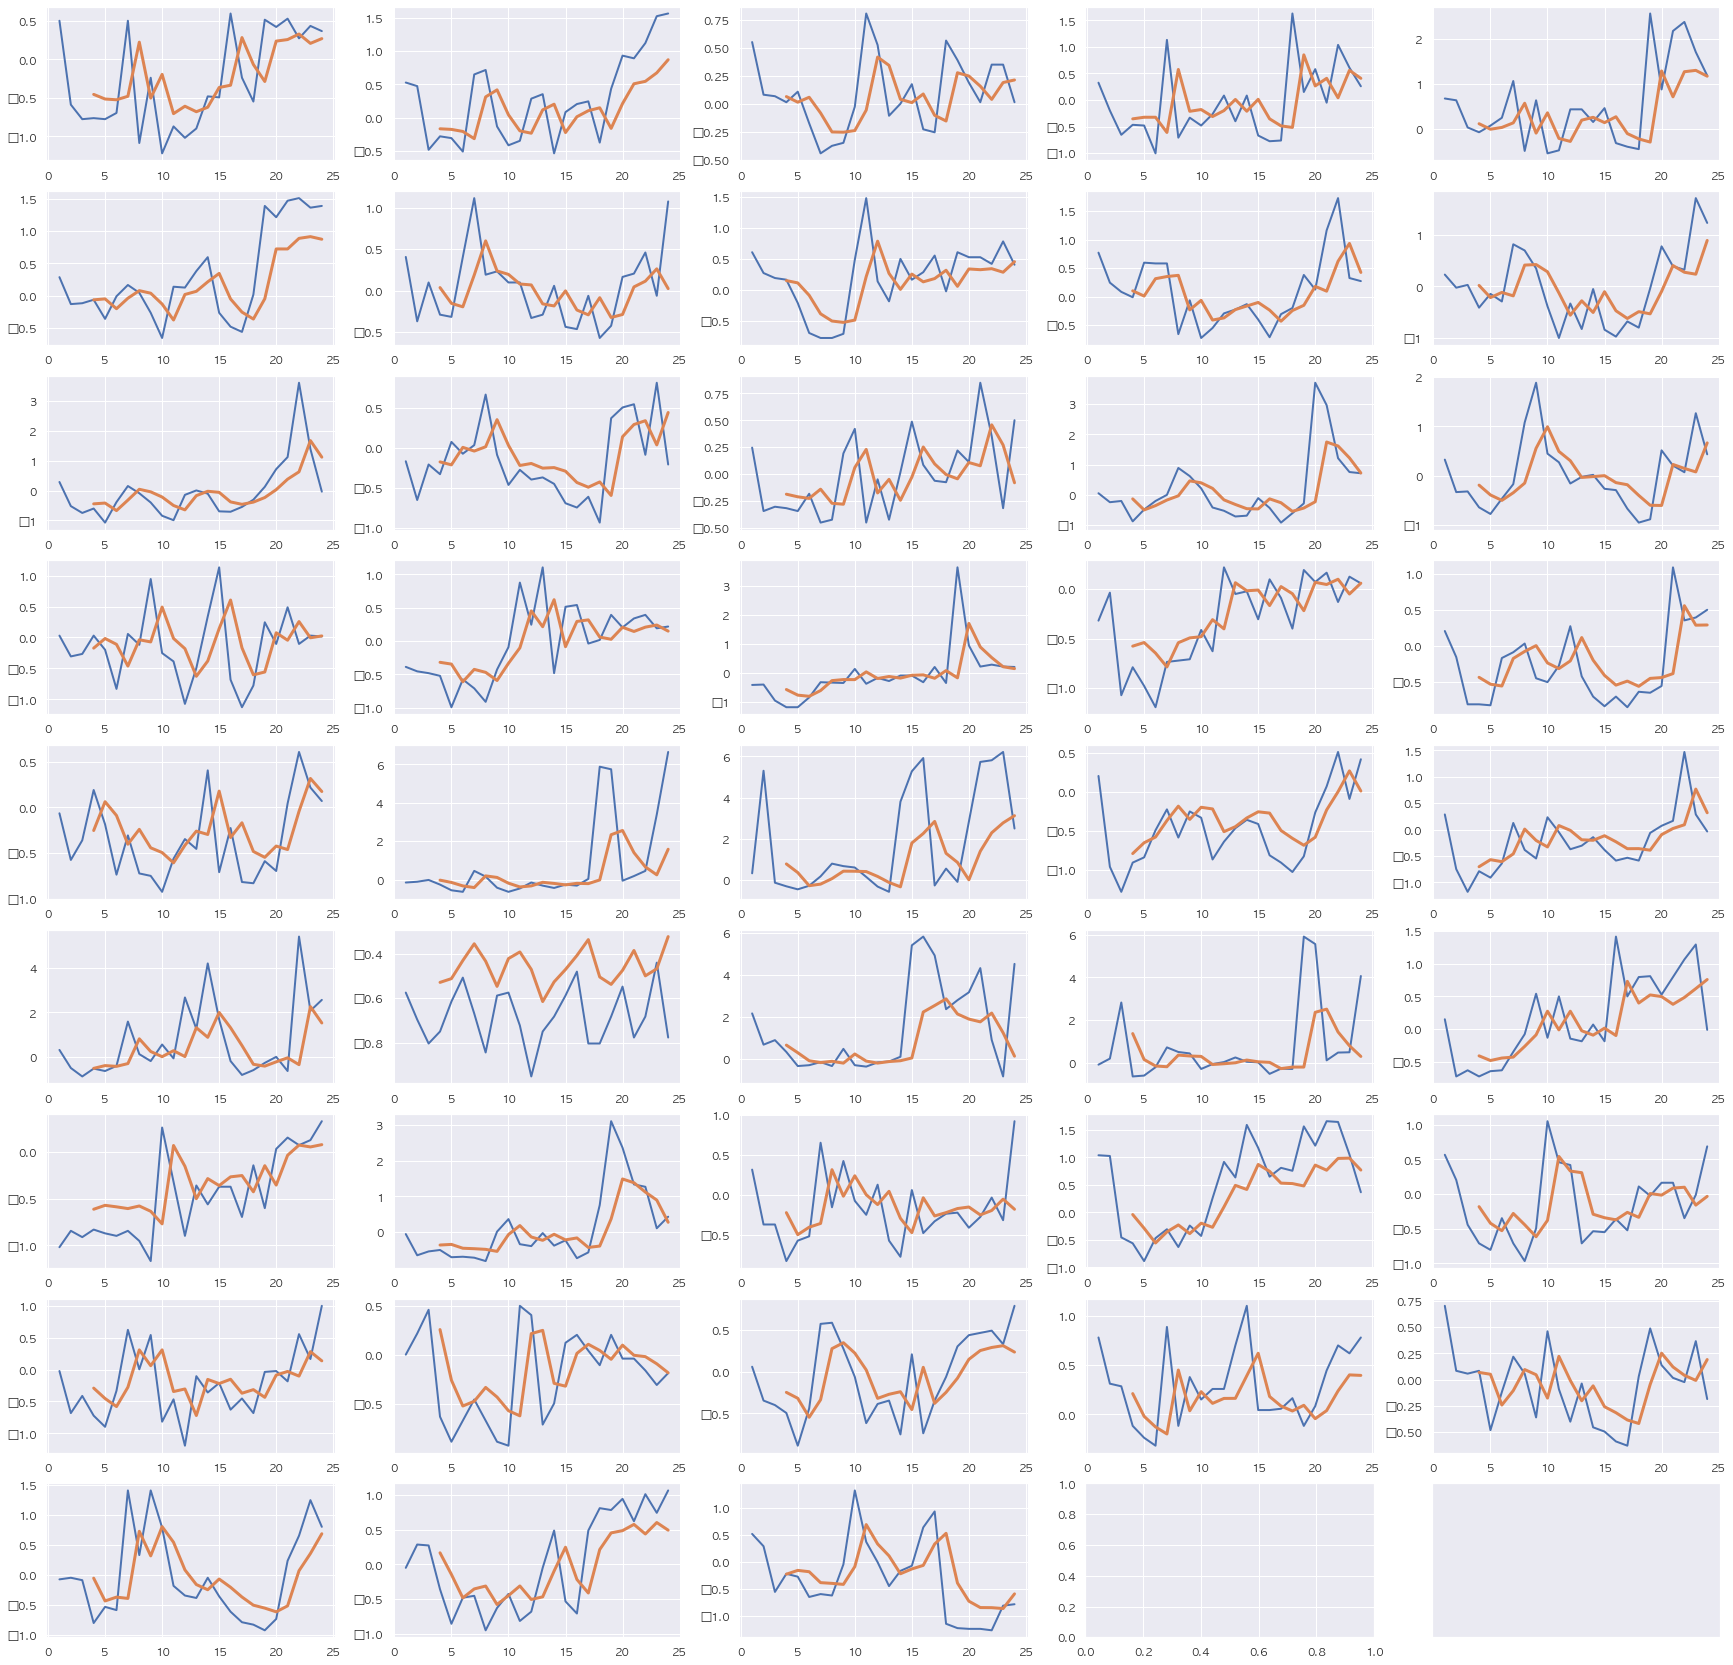

In [59]:
predict_data_length = 3
WINDOW_WIDTH = 3
fig, axes = plt.subplots(math.ceil(round(len(uni_norm['test']) / 24) / 5),5, figsize=(30,30))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cnt = 0

for split in range(0, round(len(uni_norm['test'])), 24):
    key = "{} hours".format(WINDOW_WIDTH)

    original_x_labels = [idx for idx in range(1,25)]
    predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
    original = uni_norm['test'][split:(split + 24)].values.flatten()
    predicts = []
    inputs = []

    for idx in range(0, (24 - predict_data_length)):
        inputs = uni_norm['test'][split:(split + 24)].values.flatten()[idx:predict_data_length + idx]
        inputs = inputs.reshape(-1, predict_data_length,1)
        result = uni_models[key](inputs).numpy().flatten()[2]

        predicts.append(result)
        inputs = np.append(inputs.flatten()[1:predict_data_length],result)

    sns.lineplot(original_x_labels, original, lw=2, ax=axes[
        math.floor(cnt / 5)
    ][math.floor(cnt % 5)])
    sns.lineplot(predict_x_labels, predicts, lw=3, ax=axes[
        math.floor(cnt / 5)
    ][math.floor(cnt % 5)])
        
    cnt += 1      

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

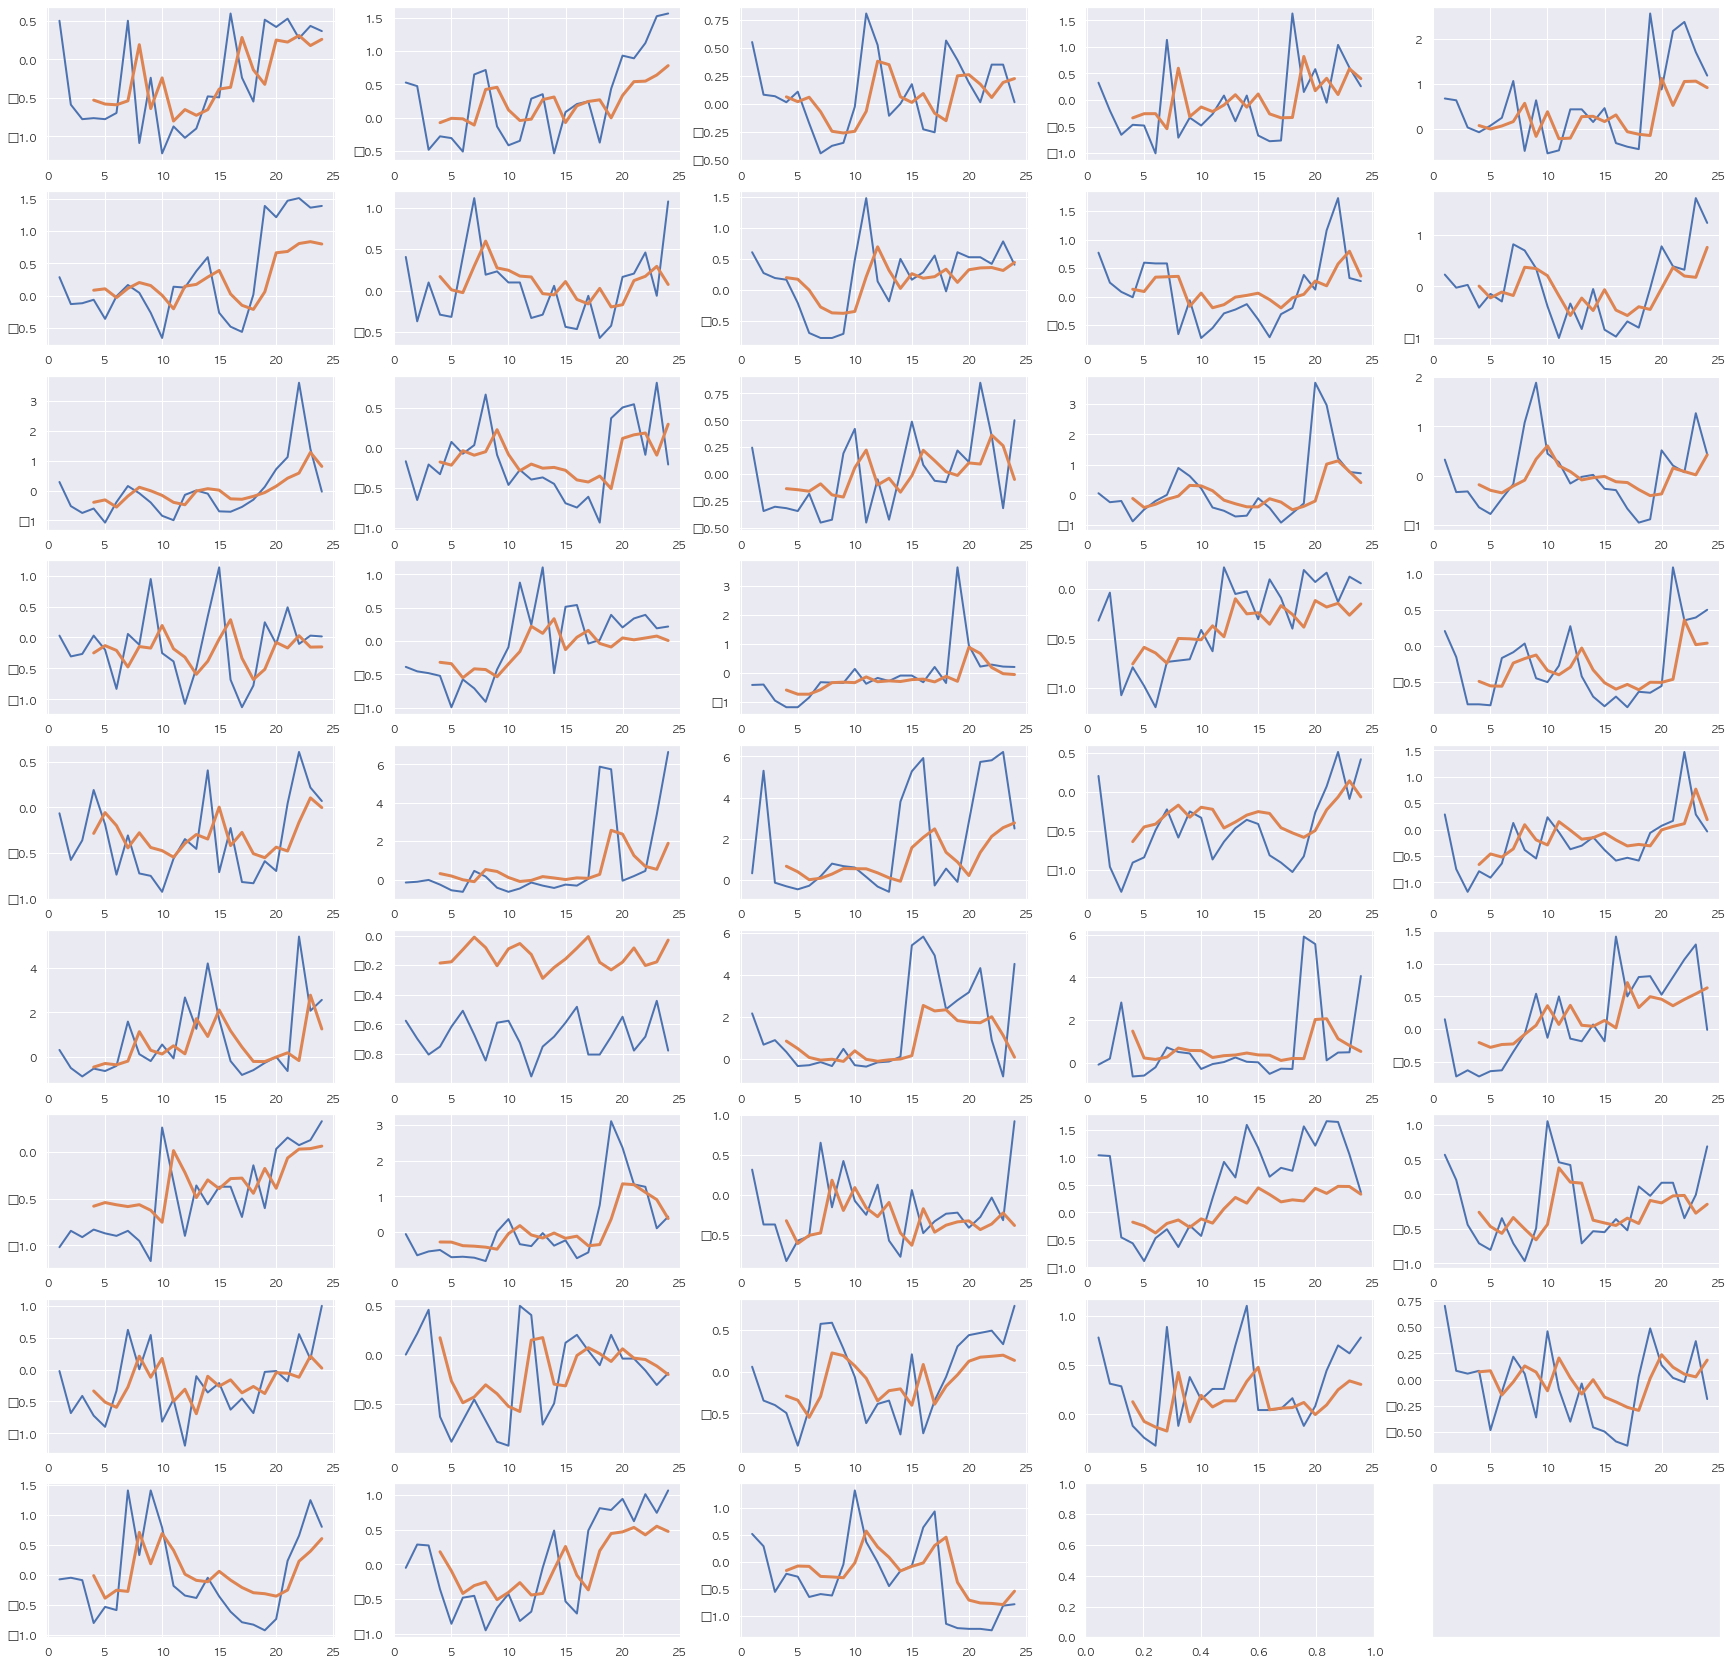

In [60]:
feature_length = 5
predict_data_length = 3
WINDOW_WIDTH = 3
fig, axes = plt.subplots(math.ceil(round(len(mul_norm['test']) / 24) / 5),5, figsize=(30,30))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cnt = 0

for split in range(0, round(len(mul_norm['test'])), 24):
    key = "{} hours".format(WINDOW_WIDTH)

    original_x_labels = [idx for idx in range(1,25)]
    predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
    original = mul_norm['test'][split:(split + 24)]['kw (15min)'].values.flatten()
    predicts = []
    inputs = []

    for idx in range(0, (24 - predict_data_length)):
        inputs = mul_norm['test'][split:(split + 24)].values[idx:predict_data_length + idx].flatten()
        inputs = inputs.reshape(-1, predict_data_length,5)
        result = mul_models[key](inputs).numpy().flatten()[2]

        predicts.append(result)
        inputs = np.append(inputs.flatten()[1:predict_data_length],result)

    sns.lineplot(original_x_labels, original, lw=2, ax=axes[
        math.floor(cnt / 5)
    ][math.floor(cnt % 5)])
    sns.lineplot(predict_x_labels, predicts, lw=3, ax=axes[
        math.floor(cnt / 5)
    ][math.floor(cnt % 5)])
        
    cnt += 1      

In [68]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import euclidean as euc

def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

predict_data_length = 3
WINDOW_WIDTH = 3
cnt = 0

evaluater = pd.DataFrame(columns=['mean dis', 'mean sim'])

for WINDOW_WIDTH in range(3, 21):
    print("WINDOW_WIDTH: {}".format(WINDOW_WIDTH))
    distances = np.array([])
    similarities = np.array([])
    for split in range(0, round(len(uni_norm['test'])), 24):
        key = "{} hours".format(WINDOW_WIDTH)

        original_x_labels = [idx for idx in range(1,25)]
        predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
        original = uni_norm['test'][split:(split + 24)].values.flatten()
        predicts = []
        inputs = []

        for idx in range(0, (24 - predict_data_length)):
            inputs = uni_norm['test'][split:(split + 24)].values.flatten()[idx:predict_data_length + idx]
            inputs = inputs.reshape(-1,predict_data_length,1)
            result = uni_models[key](inputs).numpy().flatten()[2]

            predicts.append(result)
            inputs = np.append(inputs.flatten()[1:predict_data_length],result)

        distances = np.append(distances, euc(original[predict_data_length:], predicts))
        similarities = np.append(similarities, cos_sim(original[predict_data_length:], predicts))
        cnt += 1
    evaluater.loc[key] = [distances.mean(), similarities.mean()]
        
uni_eval = evaluater.sort_values(['mean dis', 'mean sim'], ascending=[True, False]).copy()

WINDOW_WIDTH: 3
WINDOW_WIDTH: 4
WINDOW_WIDTH: 5
WINDOW_WIDTH: 6
WINDOW_WIDTH: 7
WINDOW_WIDTH: 8
WINDOW_WIDTH: 9
WINDOW_WIDTH: 10
WINDOW_WIDTH: 11
WINDOW_WIDTH: 12
WINDOW_WIDTH: 13
WINDOW_WIDTH: 14
WINDOW_WIDTH: 15
WINDOW_WIDTH: 16
WINDOW_WIDTH: 17
WINDOW_WIDTH: 18
WINDOW_WIDTH: 19
WINDOW_WIDTH: 20


In [69]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import euclidean as euc

def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

predict_data_length = 3
WINDOW_WIDTH = 3
cnt = 0

evaluater = pd.DataFrame(columns=['mean dis', 'mean sim'])

for WINDOW_WIDTH in range(3, 21):
    print("WINDOW_WIDTH: {}".format(WINDOW_WIDTH))
    distances = np.array([])
    similarities = np.array([])
    for split in range(0, round(len(mul_norm['test'])), 24):
        key = "{} hours".format(WINDOW_WIDTH)

        original_x_labels = [idx for idx in range(1,25)]
        predict_x_labels  = [idx for idx in range((predict_data_length + 1), 25)]
        original = mul_norm['test'][split:(split + 24)]['kw (15min)'].values.flatten()
        predicts = []
        inputs = []

        for idx in range(0, (24 - predict_data_length)):
            inputs = mul_norm['test'][split:(split + 24)].values[idx:predict_data_length + idx].flatten()
            inputs = inputs.reshape(-1, predict_data_length,5)
            result = mul_models[key](inputs).numpy().flatten()[2]

            predicts.append(result)
            inputs = np.append(inputs.flatten()[1:predict_data_length],result)

        distances = np.append(distances, euc(original[predict_data_length:], predicts))
        similarities = np.append(similarities, cos_sim(original[predict_data_length:], predicts))
        cnt += 1
    evaluater.loc[key] = [distances.mean(), similarities.mean()]
        
mul_eval = evaluater.sort_values(['mean dis', 'mean sim'], ascending=[True, False]).copy()

WINDOW_WIDTH: 3
WINDOW_WIDTH: 4
WINDOW_WIDTH: 5
WINDOW_WIDTH: 6
WINDOW_WIDTH: 7
WINDOW_WIDTH: 8
WINDOW_WIDTH: 9
WINDOW_WIDTH: 10
WINDOW_WIDTH: 11
WINDOW_WIDTH: 12
WINDOW_WIDTH: 13
WINDOW_WIDTH: 14
WINDOW_WIDTH: 15
WINDOW_WIDTH: 16
WINDOW_WIDTH: 17
WINDOW_WIDTH: 18
WINDOW_WIDTH: 19
WINDOW_WIDTH: 20


<AxesSubplot:>

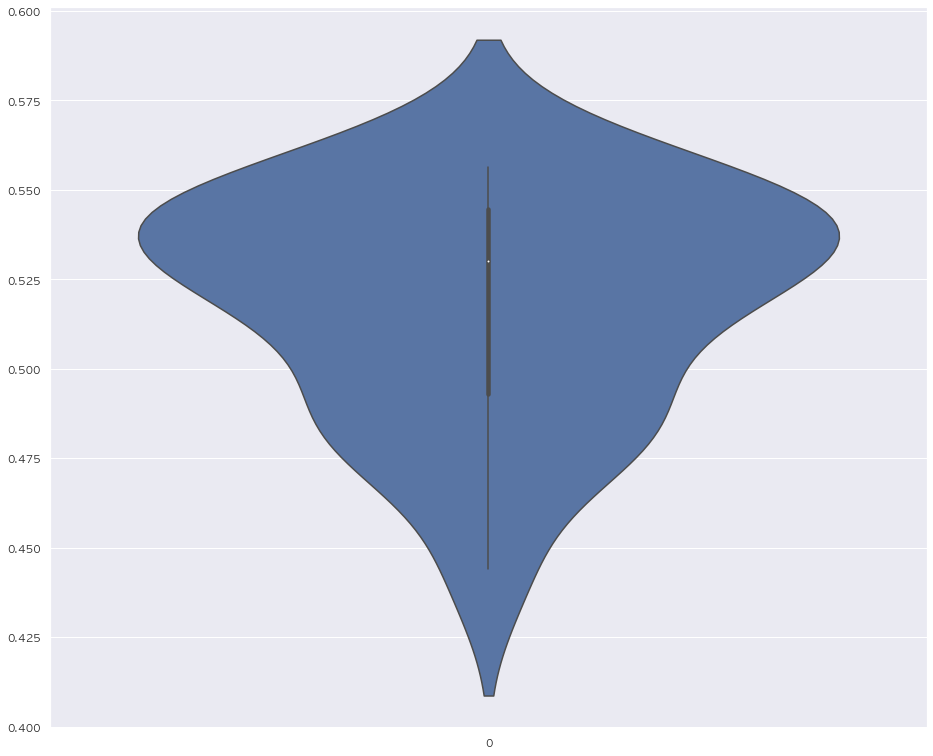

In [71]:
sns.violinplot(data=uni_eval['mean sim'])

<AxesSubplot:>

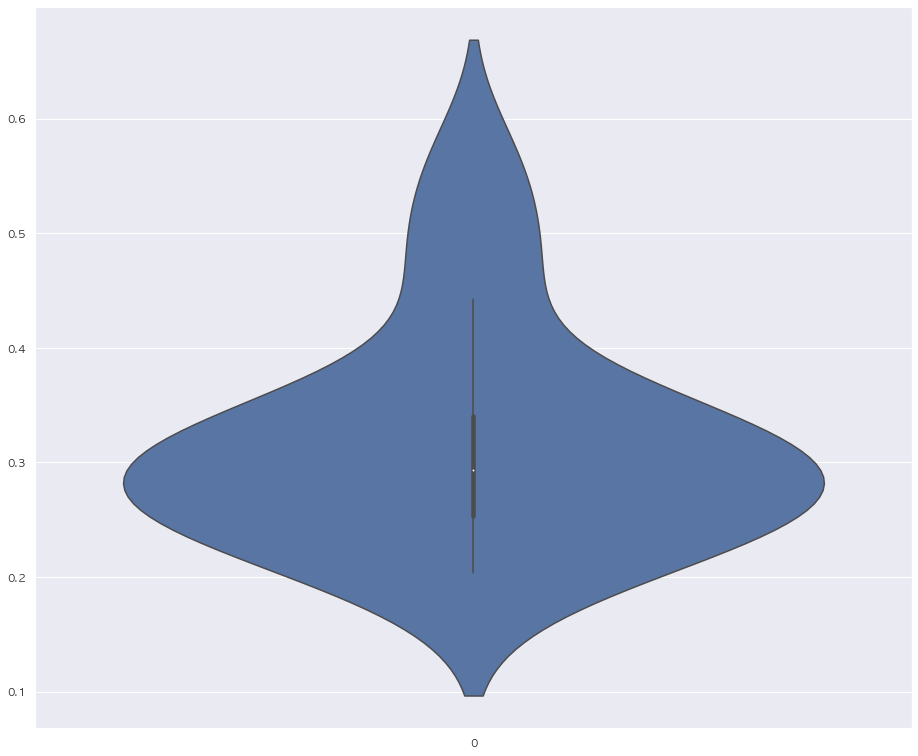

In [74]:
sns.violinplot(data=mul_eval['mean sim'])